In [2]:
import sys
# !conda install --yes --prefix {sys.prefix} scikit-learn
# !{sys.executable} -m pip install sleeper

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import importlib
from pathlib import Path

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [22]:
import requests

In [4]:
from collections import Counter

In [11]:
import fantasy_league
importlib.reload(fantasy_league)
from fantasy_league import FantasyLeague, SleeperLeague

In [12]:
data_path = Path('.') / 'data'

usfl_id = {2022: 786691248676257792}
elite_ff_id = {2021: 736885905629024256,
               2022: 784590371165425664}

sleeper_player_file = 'sleeper_players_20220722.parquet'

In [13]:
usfl_2022 = SleeperLeague('USFL', 2022, usfl_id[2022])
usfl_2022.set_datafiles(data_path, {'players': sleeper_player_file})
df_users = usfl_2022.get_league_users()
df_rosters = usfl_2022.get_league_rosters()
df_teams = usfl_2022.get_league_teams()
df_players = usfl_2022.get_league_players()

Pulling users from Sleeper API.
Pulling roster data from Sleeper API.
Returning current teams dataframe.
Reading parquet file for players.


In [14]:
elite_2021 = SleeperLeague('Elite Football League', 2021, elite_ff_id[2021])
elite_2021.set_datafiles(data_path, {'players': sleeper_player_file})
df_users = elite_2021.get_league_users()
df_rosters = elite_2021.get_league_rosters()
df_teams = elite_2021.get_league_teams()
df_players = elite_2021.get_league_players()

Pulling users from Sleeper API.
Pulling roster data from Sleeper API.
Returning current teams dataframe.
Reading parquet file for players.


In [15]:
elite_2021.roster_positions

['DEF', 'K', 'QB', 'RB', 'TE', 'WR']

In [489]:
print(df_users.columns.values)
print(df_rosters.columns.values)
print(df_teams.columns.values)
print(df_players.columns.values)


['user_id' 'team_name' 'display_name' 'is_commish']
['owner_id' 'roster_id' 'player_id' 'roster_spot']
['owner_id' 'roster_id' 'division' 'wins' 'losses' 'ties' 'points_for'
 'points_against' 'possible_points' 'record' 'rostered' 'starters' 'bench'
 'ir' 'taxi' 'roster_locked']
['practice_participation' 'years_exp' 'injury_body_part'
 'depth_chart_order' 'metadata' 'status' 'injury_status' 'position'
 'practice_description' 'number' 'last_name' 'injury_start_date' 'team'
 'age' 'full_name' 'injury_notes' 'search_rank' 'depth_chart_position'
 'player_id' 'first_name' 'fantasy_pos']


In [16]:
df_teams

,owner_id,roster_id,division,wins,losses,ties,points_for,points_against,possible_points,record,rostered,starters,bench,ir,taxi,roster_locked
0,736884867563933696,1,1,7,7,0,2334.34,2199.66,2462.34,LWWLLWWLLLWWLW,22,12,6,4,0,0
1,403652925030690816,2,2,7,7,0,2299.09,2264.47,2530.62,LWLLWLWLWLWLWW,24,12,8,4,0,0
2,599301523998040064,3,1,6,8,0,1530.64,2089.68,2377.53,WLWLWWLLLLLLWW,21,12,5,4,0,0
3,687087002591494144,4,2,11,3,0,2508.19,2027.32,2777.94,WWWWWLWWLWWWWL,23,12,7,4,0,0
4,486383191502876672,5,1,8,6,0,2444.65,2178.86,2628.97,LLWWWLWWWWLWLL,23,12,8,3,0,0
5,700041879613415424,6,2,5,9,0,2159.34,2262.71,2377.75,WWLLLWLWLWLLLL,22,12,8,2,0,0
6,548284571069947904,7,1,12,2,0,2287.77,1993.55,2549.00,LWLWWWWWWWWWWW,23,12,8,3,0,0
7,772305076990783488,8,2,2,12,0,1844.77,2387.82,2151.57,LLLLLLLLWLWLLL,18,12,4,2,0,0
8,771628777896861696,9,1,4,10,0,1991.90,2277.99,2248.20,WLLWLWLLLWLLLL,20,12,7,1,0,0
9,507622071747100672,10,2,8,6,0,2409.96,2128.59,2662.54,WLWWLLLWWLLWWW,24,12,8,4,0,0


In [17]:
player_pos_map = dict(zip(df_players.player_id, df_players.fantasy_pos))

In [20]:
# df_players.query('fantasy_pos == "DEF"')

In [120]:
def roster_distribution(week):
    starters = set(week.starters)
    bench_points = 0
    valid_starters = 0
    for player, points in week.players_points.items():
        if player not in starters:
            bench_points += points
        elif points > 0:
            valid_starters += 1
    
    ignore_players = ['0']
    pos_order = ['qb', 'rb', 'wr', 'te', 'k', 'def']
    start_pos = Counter({'start_' + pos: 0 for pos in pos_order})
    roster_pos = Counter({'roster_' + pos: 0 for pos in pos_order})
    pos_score = Counter({pos + '_score': 0 for pos in pos_order})
    
    roster_stats = Counter({'bench_points': bench_points, 'active_starters': valid_starters})
    start_pos.update(Counter(['start_' + player_pos_map.get(starter, '').lower() for starter in starters if starter not in ignore_players]))
    roster_pos.update(Counter(['roster_' + player_pos_map.get(player, '').lower() for player in week.players if player not in ignore_players]))
    starter_scores = [(player_pos_map.get(player,'').lower() + '_score', score)
                       for player, score in week.players_points.items()
                       if (player not in ignore_players) and (player in starters)]
    pos_score.update(pd.DataFrame(starter_scores, columns=['player', 'score']).groupby('player').score.sum().to_dict())
    
    return_counter = Counter()
    return_counter.update(roster_stats)
    return_counter.update(start_pos)
    return_counter.update(roster_pos)
    return_counter.update(pos_score)
    return return_counter
    
def non_starter_points(week):
    starters = set(week.starters)
    bench_points = 0
    for player, points in week.players_points.items():
        if player not in starters:
            bench_points += points
    return bench_points

def valid_starters(starters_points):
    valid_starters = 0
    for points in starters_points:
        if points > 0: valid_starters += 1
    return valid_starters

def adjust_weekly_data_columns(df):
    start_columns = ['roster_id', 'week', 'matchup_id', 'points', 'bench_points', 'active_starters']
    drop_columns = ['starters', 'starters_points', 'players', 'players_points', 'custom_points']
    new_column_order = start_columns + [col for col in df.columns if col not in (start_columns + drop_columns)]
    df = df[new_column_order]
    return df

In [121]:
# %%timeit
df_list = []
for week in range(1, 18): #18
    sleeper_rosters = f'https://api.sleeper.app/v1/league/{736885905629024256}/matchups/{week}'
    response = requests.get(sleeper_rosters)
    rosters_json = response.json()
    df_scores = (
        pd.DataFrame(rosters_json)
        .assign(week = week,
                matchup_id = lambda df: df.matchup_id.fillna(-1).astype(np.int8))
        .pipe(lambda df: df.assign(**pd.DataFrame(df.apply(roster_distribution, axis=1).tolist())))
#         .drop(columns=['starters', 'starters_points', 'players', 'players_points', 'custom_points'])
        .pipe(adjust_weekly_data_columns)
#         [['roster_id', 'week', 'matchup_id', 'points', 
#           'bench_points', 'num_starters',
#           'start_rb', 'start_wr', 'roster_rb', 'roster_wr']]
    )
    df_list.append(df_scores)
df_scores = pd.concat(df_list).reset_index(drop=True)
df_scores = (
    df_scores         
    .merge(df_scores[['week', 'matchup_id', 'roster_id', 'points']], on=['week', 'matchup_id'], suffixes=('', '_opp'), how='left')
    .rename(columns={'roster_id_opp': 'opponent_id', 'points_opp': 'opp_points'})
    .query('roster_id != opponent_id')
    .assign(result = lambda df: np.select([df.matchup_id == -1,
                                           df.points > df.opp_points, 
                                           df.points == df.opp_points, 
                                           df.points < df.opp_points],
                                          ['No matchup', 'Win', 'Tie', 'Loss']),
            opponent_id = lambda df: np.where(df.matchup_id == -1, -1, df.opponent_id),
            opp_points = lambda df: np.where(df.matchup_id == -1, 0, df.opp_points))
)
# df_scores

In [123]:
# rosters_json[0]
# pd.Series([{'a': 1.5, 'a': 2.5, 'b': 3, 'c': 4}])
# starter_scores = [(player_pos_map.get(player,'').lower() + '_score', score)
#                        for player, score in week['players_points'].items()
#                        if (player not in ['0']) and (player in week['starters'])]
# pd.DataFrame(starter_scores, columns=['player', 'score']).groupby('player').score.sum().to_dict()
# starter_scores


In [126]:
df_scores.head()

,roster_id,week,matchup_id,points,bench_points,active_starters,start_qb,start_rb,start_wr,start_te,start_k,start_def,roster_qb,roster_rb,roster_wr,roster_te,roster_k,roster_def,qb_score,rb_score,wr_score,te_score,k_score,def_score,opponent_id,opp_points,result
1,1,1,1,153.19,43.91,11,2,3,4,1,1,1,3,4,7,3,1,1,46.74,13.70,34.90,20.85,11.0,26.0,9,188.85,Loss
3,2,1,5,200.08,54.08,12,2,2,5,1,1,1,4,6,5,1,1,1,28.03,25.80,86.45,21.80,12.0,26.0,6,216.99,Loss
5,3,1,2,163.70,24.90,10,2,3,4,1,1,1,2,6,6,2,1,1,55.45,32.25,37.00,0.00,4.0,35.0,5,151.71,Win
7,4,1,4,223.17,107.35,12,2,2,5,1,1,1,4,4,7,2,1,1,81.97,14.55,91.25,8.40,3.0,24.0,8,111.20,Win
8,5,1,2,151.71,60.15,11,2,3,4,1,1,1,2,6,7,2,1,1,39.76,35.80,46.75,2.40,6.0,21.0,3,163.70,Loss


In [135]:
help(pd.DataFrame.melt)

Help on function melt in module pandas.core.frame:

melt(self, id_vars=None, value_vars=None, var_name=None, value_name='value', col_level: 'Level | None' = None, ignore_index: 'bool' = True) -> 'DataFrame'
    Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
    
    This function is useful to massage a DataFrame into a format where one
    or more columns are identifier variables (`id_vars`), while all other
    columns, considered measured variables (`value_vars`), are "unpivoted" to
    the row axis, leaving just two non-identifier columns, 'variable' and
    'value'.
    
    Parameters
    ----------
    id_vars : tuple, list, or ndarray, optional
        Column(s) to use as identifier variables.
    value_vars : tuple, list, or ndarray, optional
        Column(s) to unpivot. If not specified, uses all columns that
        are not set as `id_vars`.
    var_name : scalar
        Name to use for the 'variable' column. If None it uses
        ``frame

In [166]:
dir(df_scores.filter(like='_score').columns)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_accessors',
 '_arith_method',
 

In [176]:
df_scores.filter(like='_score').columns.to_series()[::-1].values

array(['def_score', 'k_score', 'te_score', 'wr_score', 'rb_score',
       'qb_score'], dtype=object)

In [190]:
df_viz = (df_scores.query('roster_id == 1')
 .melt('week', df_scores.filter(like='_score').columns, var_name='position', value_name='score')
)
# df_viz = (df_scores.query('roster_id == 1')
#  [['week'] + df_scores.filter(like='_score').columns.to_series()[::-1].values.tolist()]
# )
df_viz

,week,position,score
0,1,qb_score,46.74
1,2,qb_score,41.87
2,3,qb_score,57.73
3,4,qb_score,33.55
4,5,qb_score,37.02
5,6,qb_score,64.05
6,7,qb_score,73.85
7,8,qb_score,49.20
8,9,qb_score,39.51
9,10,qb_score,38.12


C:\Users\jaime.avendano\anaconda3\envs\ds\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


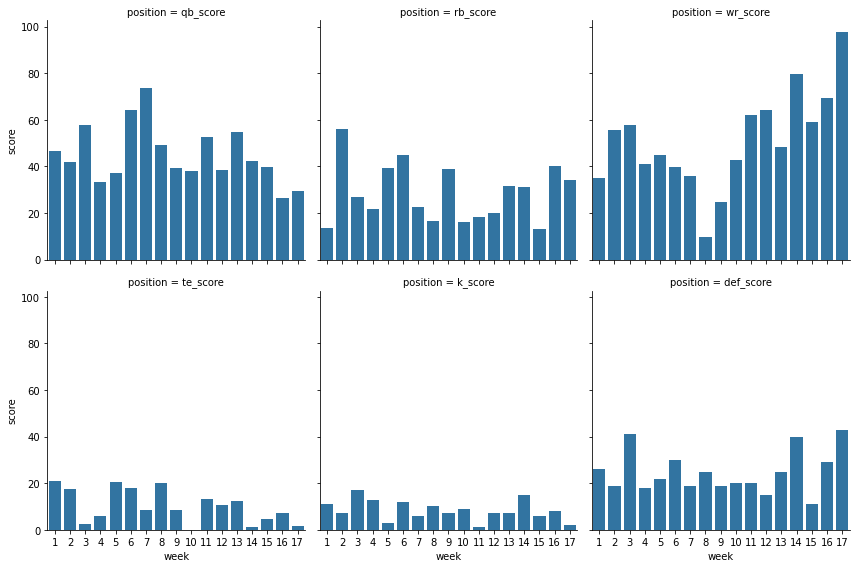

In [201]:
# plt.figure(figsize=(10, 20))
# sns.barplot(x='week', y='score', hue='position', dodge=False, data=df_viz);
# df_viz.set_index('week').plot(kind='bar', stacked=True, figsize=(10,7));
# sns.barplot(x='week', y='score', hue='position', dodge=False, data=df_viz);
g = sns.FacetGrid(df_viz, col='position', col_wrap=3, height=4)
g.map(sns.barplot, 'week', 'score');

In [322]:
(df_scores
 .query('num_starters >= 11')
 .groupby('roster_rb', as_index=False)
 .agg(points_mean = ('points', 'mean'),
      points_std = ('points', 'std'),
      count = ('points', 'count'))
 .sort_values('points_mean')
)

,roster_rb,points_mean,points_std,count
0,3,155.375000,31.108910,4
2,5,162.704419,29.358755,43
5,8,164.902500,35.237648,8
3,6,166.079574,29.261544,47
4,7,167.960800,24.100657,25
1,4,169.933636,31.529826,11


In [323]:
(df_scores
 .query('num_starters >= 11')
 .groupby('roster_wr', as_index=False)
 .agg(points_mean = ('points', 'mean'),
      points_std = ('points', 'std'),
      count = ('points', 'count'))
 .sort_values('points_mean')
)

,roster_wr,points_mean,points_std,count
0,4,147.820000,44.165890,2
4,8,160.734000,25.276354,25
3,7,162.784898,27.071723,49
2,6,164.866341,30.962414,41
6,10,171.155000,32.138003,2
5,9,172.714167,27.880179,12
1,5,192.312857,27.426589,7


In [324]:
(df_scores
 .query('num_starters >= 11 and roster_wr == 5')
)

,roster_id,week,matchup_id,points,bench_points,num_starters,start_rb,start_wr,roster_rb,roster_wr,start_rb_wr,roster_rb_wr
1,2,1,5.0,200.08,54.08,12,2,5,6,5,2-5,6-5
11,2,2,4.0,211.03,47.95,12,2,5,6,5,2-5,6-5
21,2,3,5.0,200.12,23.71,12,3,4,7,5,3-4,7-5
79,10,8,5.0,163.95,10.45,12,3,4,7,5,3-4,7-5
89,10,9,3.0,144.55,35.15,12,3,4,6,5,3-4,6-5
129,10,13,4.0,219.59,57.20,12,2,5,8,5,2-5,8-5
139,10,14,4.0,206.87,80.76,12,3,4,7,5,3-4,7-5


In [318]:
# def non_starter_points(week):
#     starters = set(week.starters)
#     bench_points = 0
#     for player, points in week.players_points.items():
#         if player not in starters:
#             bench_points += points
#     return bench_points

# df_scores = (pd.DataFrame(rosters_json)
#  .assign(week = 1,
#          bench_points = lambda df: df.apply(non_starter_points, axis=1))
#  [['roster_id', 'week', 'matchup_id', 'points', 'bench_points']]
# )
# df_scores = df_scores.assign(roster_str = lambda df: 'r' + df.roster_id.astype(str)).reset_index(drop=True)
df_viz = (df_scores
 .query('num_starters >= 11')
 .groupby(['week', 'start_rb', 'start_wr', 'rb_wr'], as_index=False)
 .agg({'points': 'mean'})
#  .assign(rb_wr = lambda df: df.start_rb.astype(str) + '-' + df.start_wr.astype(str))
)
df_viz.rb_wr.value_counts()

2-5    17
3-4    17
2-4    11
4-3     4
Name: rb_wr, dtype: int64

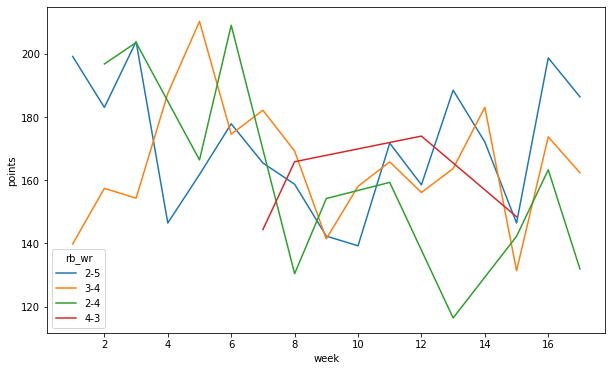

In [302]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='week', y='points', hue='rb_wr', data=df_viz);

In [188]:
df_viz = (
    df_teams
    .merge(df_users, left_on=['owner_id'], right_on=['user_id'], how='left')
    .merge(df_scores, on=['roster_id'])
    [['display_name', 'roster_id', 'week', 'matchup_id', 'points', 'bench_points']]
)
df_viz.head()

,display_name,roster_id,week,matchup_id,points,bench_points
0,Bainer94,1,1,1.0,153.19,43.91
1,Bainer94,1,2,2.0,196.82,18.85
2,Bainer94,1,3,3.0,202.98,47.75
3,Bainer94,1,4,1.0,133.80,52.65
4,Bainer94,1,5,2.0,166.42,38.10


In [201]:
(df_viz
 .groupby(['display_name', 'roster_id'])
 .agg({'points': 'mean', 'bench_points': 'mean'})
 .sort_values('points')
 .reset_index()
)

,display_name,roster_id,points,bench_points
0,hartdustin26,3,117.209412,73.967647
1,Mjkeyes,8,130.078824,37.926471
2,Hollywood1004,9,143.742353,34.758824
3,javendano585,6,154.137647,42.629412
4,TheFantasyHeel,7,161.490000,43.004118
5,dadorknight,2,166.098235,41.715294
6,Bainer94,1,168.010000,28.211765
7,gramkind,5,170.278235,49.030000
8,Egus03,10,173.784118,49.045882
9,jobas1123,4,175.458824,49.958235


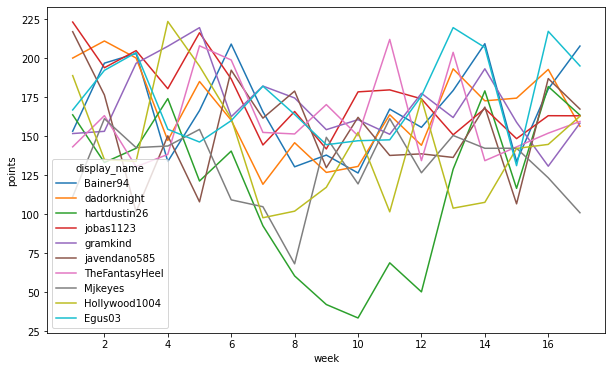

In [195]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='week', y='points', hue='display_name', data=df_viz);

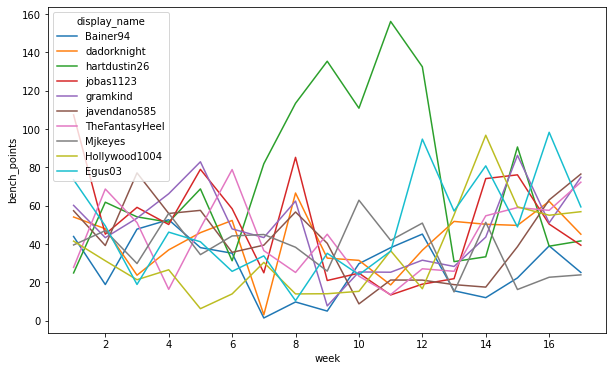

In [196]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='week', y='bench_points', hue='display_name', data=df_viz);

In [88]:
roster_players = set(df_rosters.player_id)
print('Total players: ', df_players.shape[0])

df_filtered = (
    df_players
    .query('''(player_id not in @roster_players) and (~depth_chart_position.isna()) and (depth_chart_order == 1)''')
#     .fantasy_pos.value_counts()
)
print('Filtered players: ', df_filtered.shape[0])
# df_filtered.depth_chart_position.value_counts()

Total players:  4706
Filtered players:  108


In [89]:
df_filtered.query('fantasy_pos == "TE"')

,practice_participation,last_name,metadata,first_name,age,injury_start_date,status,position,depth_chart_position,depth_chart_order,player_id,injury_status,years_exp,practice_description,team,full_name,number,injury_body_part,injury_notes,search_rank,fantasy_pos
1790,None,Thomas,None,Ian,26,None,Active,TE,LTE,1,4995,Questionable,4,None,CAR,Ian Thomas,80,None,None,336,TE
4807,None,Ricci,None,Giovanni,25,None,Active,FB,FB,1,7216,None,2,None,CAR,Giovanni Ricci,45,None,None,9999999,TE
5212,None,Gilliam,None,Reggie,24,None,Active,FB,FB,1,7204,None,2,None,BUF,Reggie Gilliam,41,None,None,9999999,TE
5616,None,Pierce,None,Chris,23,None,Active,TE,RTE,1,8634,None,0,None,ARI,Chris Pierce,49,None,None,9999999,TE
5816,None,Givan,None,Nolan,None,None,Active,TE,RTE,1,8817,None,0,None,DET,Nolan Givan,43,None,None,9999999,TE
7965,None,Carter,None,Roger,23,None,Active,TE,RTE,1,8747,None,0,None,LAR,Roger Carter,49,None,None,9999999,TE
8337,None,Beck,{'injury_override_regular_2020_5': 'COV'},Andrew,26,None,Active,FB,FB,1,6323,None,3,None,DEN,Andrew Beck,83,None,None,9999999,TE


In [91]:
df = (
    df_teams
    .merge(df_users, left_on=['owner_id'], right_on=['user_id'], how='left')
    .drop(columns=['user_id'])
    .merge(df_rosters, on=['owner_id', 'roster_id'], how='left')
    .pipe(lambda df: df.assign(**df.roster_spot.str.get_dummies()))
    .merge(df_players, on=['player_id'], how='left')
#     .pipe(lambda df: df.assign(**df.fantasy_pos.str.get_dummies()))
    .pipe(lambda df: df.assign(**pd.Series(np.where(df.roster_spot == 'taxi', '', df.fantasy_pos)).str.get_dummies())) 
    .pipe(lambda df: df.assign(**pd.Series(np.where(df.roster_spot == 'taxi', df.fantasy_pos + '_TX', '')).str.get_dummies()))
)
df.head()

,owner_id,roster_id,wins,waiver_position,waiver_budget_used,total_moves,ties,losses,fpts,division,team_name,display_name,is_commish,player_id,roster_spot,bench,ir,starter,taxi,practice_participation,last_name,metadata,first_name,age,injury_start_date,status,position,depth_chart_position,depth_chart_order,injury_status,years_exp,practice_description,team,full_name,number,injury_body_part,injury_notes,search_rank,fantasy_pos,DB,DB/LB,DL,DL/LB,K,LB,QB,RB,TE,WR,DB_TX,DL_TX,K_TX,LB_TX,QB_TX,RB_TX,TE_TX,WR_TX
0,715231056025980928,1,0,15,35,0,0,0,0,1,Boston Breakers,GermyBeast,0,6799,starter,0,0,1,0,None,Delpit,None,Grant,23,None,Active,DB,SS,1,None,2,None,CLE,Grant Delpit,22,None,Delpit was carted off the practice field and w...,522,DB,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,715231056025980928,1,0,15,35,0,0,0,0,1,Boston Breakers,GermyBeast,0,6065,bench,1,0,0,0,None,Barton,None,Cody,25,None,Active,LB,MLB,1,None,3,None,SEA,Cody Barton,57,None,None,394,LB,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,715231056025980928,1,0,15,35,0,0,0,0,1,Boston Breakers,GermyBeast,0,8899,taxi,0,0,0,1,None,Emili,None,Prince,None,None,Active,DT,None,None,None,0,None,BUF,Prince Emili,94,None,None,9999999,DL,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,715231056025980928,1,0,15,35,0,0,0,0,1,Boston Breakers,GermyBeast,0,5051,starter,0,0,1,0,None,Jackson,None,Donte,26,None,Active,CB,LCB,1,None,4,None,CAR,Donte Jackson,26,None,None,9999999,DB,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,715231056025980928,1,0,15,35,0,0,0,0,1,Boston Breakers,GermyBeast,0,7672,bench,1,0,0,0,None,Jones,None,Ernest,22,None,Active,LB,RILB,1,None,1,None,LAR,Ernest Jones,53,None,None,430,LB,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
def get_sorted_unique_positions(df: pd.DataFrame):
    sort_list = ['QB', 'RB', 'WR', 'TE', 'K', 'DL', 'DL/LB', 'LB', 'DB/LB', 'DB']
    sort_dict = {pos: i for i, pos in enumerate(sort_list)}
    
    sorted_pos = (
        df[['fantasy_pos']]
        .drop_duplicates()
        .assign(sort_order = lambda df: df.fantasy_pos.map(sort_dict))
        .sort_values('sort_order')
        .fantasy_pos
        .values
    )
    
    return sorted_pos
    

agg_cols = {'starter': sum, 'bench': sum, 'ir': sum, 'taxi': sum}
for col in get_sorted_unique_positions(df.query('roster_spot != "taxi"')):
    agg_cols[col] = sum
for col in get_sorted_unique_positions(df.query('roster_spot == "taxi"')):
    agg_cols[col + '_TX'] = sum


df_summ = (
    df
    .groupby(['roster_id', 'team_name', 'display_name'])
    .agg(agg_cols)
#     .agg({'starter': sum, 'bench': sum, 'ir': sum, 'taxi': sum,
#           'DL': sum, 'DL/LB': sum, 'LB': sum, 'DB/LB': sum, 'DB': sum, 'QB': sum, 'RB': sum, 'WR': sum, 'TE': sum, 'K': sum,
#           'DL_TX': sum, 'LB_TX': sum, 'DB_TX': sum, 'QB_TX': sum, 'RB_TX': sum, 'WR_TX': sum, 'TE_TX': sum, 'K_TX': sum})
    .assign(total = lambda df: df[['starter', 'bench', 'ir', 'taxi']].sum(axis=1),
            roster_locked = lambda df: (df.starter + df.bench > 40).astype(np.int8))
    .reset_index()
)
df_summ

,roster_id,team_name,display_name,starter,bench,ir,taxi,QB,RB,WR,TE,K,DL,DL/LB,LB,DB/LB,DB,QB_TX,RB_TX,WR_TX,TE_TX,K_TX,DL_TX,LB_TX,DB_TX,total,roster_locked
0,1,Boston Breakers,GermyBeast,20,20,0,3,2,5,7,5,1,0,9,4,0,7,0,1,1,0,0,1,0,0,43,0
1,2,Tampa Bay Bandits,emerald247,20,19,0,0,2,9,5,2,2,5,3,4,0,7,0,0,0,0,0,0,0,0,39,0
2,3,Los Angeles Express,RedPhoenix437,20,19,3,5,4,5,6,6,1,2,3,5,0,10,1,0,0,0,0,2,0,2,47,0
3,4,Jacksonville Bulls,pauly102,20,20,0,5,3,4,6,2,2,4,5,5,0,9,1,1,1,0,0,0,0,2,45,0
4,5,Orlando Renegades,Mrhawke19,20,23,2,5,2,7,9,4,1,6,4,5,0,7,1,2,1,0,0,0,1,0,50,1
5,6,Pittsburgh Maulers,haydenshaw85,20,20,1,4,2,2,9,1,1,8,3,3,0,12,0,1,0,0,0,2,0,1,45,0
6,7,Memphis Showboats,SBB238,19,22,0,0,4,7,6,4,0,3,3,6,1,7,0,0,0,0,0,0,0,0,41,1
7,8,Houston Gamblers ♥️♠️♦️♣️,Bolty1028,20,20,0,5,3,7,9,3,1,4,2,3,1,7,0,2,1,2,0,0,0,0,45,0
8,9,Detriot Drive,Monty0813,20,20,0,0,3,5,8,2,1,6,1,3,0,11,0,0,0,0,0,0,0,0,40,0
9,10,Washington Federals,michaelp42983,20,29,0,0,3,6,10,4,2,9,3,4,0,8,0,0,0,0,0,0,0,0,49,1


In [93]:
df_summ.query('roster_locked == 0 and taxi > 0').describe()

,roster_id,starter,bench,ir,taxi,QB,RB,WR,TE,K,DL,DL/LB,LB,DB/LB,DB,QB_TX,RB_TX,WR_TX,TE_TX,K_TX,DL_TX,LB_TX,DB_TX,total,roster_locked
count,11.000000,11.0,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0,11.000000,11.0
mean,10.000000,20.0,19.636364,0.636364,4.454545,2.727273,5.181818,7.909091,2.818182,1.363636,4.545455,2.909091,4.727273,0.181818,7.909091,0.272727,0.727273,0.545455,0.272727,0.090909,1.090909,0.454545,1.0,44.727273,0.0
std,6.115554,0.0,0.504525,1.026911,0.820200,0.646670,1.601136,2.022600,1.601136,0.504525,2.161649,2.385563,1.190874,0.404520,2.071451,0.467099,0.786245,0.687552,0.646670,0.301511,0.943880,0.522233,1.0,1.272078,0.0
min,1.000000,20.0,19.000000,0.000000,3.000000,2.000000,2.000000,6.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,43.000000,0.0
25%,5.000000,20.0,19.000000,0.000000,4.000000,2.000000,4.500000,6.500000,2.000000,1.000000,4.000000,1.000000,4.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,44.000000,0.0
50%,11.000000,20.0,20.000000,0.000000,5.000000,3.000000,6.000000,8.000000,2.000000,1.000000,5.000000,3.000000,5.000000,0.000000,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,45.000000,0.0
75%,14.000000,20.0,20.000000,1.000000,5.000000,3.000000,6.000000,8.500000,3.500000,2.000000,6.000000,3.000000,6.000000,0.000000,9.500000,0.500000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.5,45.000000,0.0
max,20.000000,20.0,20.000000,3.000000,5.000000,4.000000,7.000000,13.000000,6.000000,2.000000,8.000000,9.000000,6.000000,1.000000,12.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,3.0,47.000000,0.0
